In [7]:
#------------ Import tools ---------------
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import numpy as np
import glob
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

In [3]:
#--------- Importing and cleaning 2022 NIBRS data for human trafficking ---------------
#Read in the NIBRS Agencies for 2022
agencies_2022 = pd.read_feather('/lustre/work/client/users/mlangstonsmith/nibrs/nibrs_2022/agencies_2022.feather')
offense_2022 = pd.read_feather('/lustre/work/client/users/mlangstonsmith/nibrs/nibrs_2022/nibrs_offense_2022.feather')
incident_2022 = pd.read_feather('/lustre/work/client/users/mlangstonsmith/nibrs/nibrs_2022/nibrs_incident_2022.feather')

#Join 2022 incidents and offenses, keeping the rows of incidents with a left join
inc_off_merge = pd.merge(offense_2022,incident_2022, left_on="incident_id", right_on="incident_id", how='left')

#Include only offenses within human trafficking
# Use isin() method to check if offense_code is '64A' or '64B'
inc_off_merge['is_traf'] = inc_off_merge['offense_code'].isin(['64A', '64B'])

#bring in the agencies by merging on the agnecy ID
merged_trafv2 = pd.merge(inc_off_merge, agencies_2022, left_on='agency_id', right_on='agency_id', how='left')

#Eliminate incidents that are not human trafficking
merged_trafv3 = merged_trafv2[merged_trafv2['is_traf']]

In [ ]:
#----------------------- Cleaning the names of agencies to prepare for a fuzzy match to US cities ---------------------
# Define the substrings to remove from ncic_agency_name
substrings_to_remove = ["PD ", " PD", " CO SO ", " COUNTY SHERRIFFS OFFICE", " POLICE DEPARTMENT", " POLICE DEPT"]

# Method 1: Using str.replace() for each substring
for substring in substrings_to_remove:
    merged_trafv3['ncic_agency_name'] = merged_trafv3['ncic_agency_name'].str.replace(substring, "")

#Add state codes to both the NIBRS data and the cities list in order to improve the matching accuracy
merged_trafv3["name_and_state"] = merged_trafv3[["ncic_agency_name","state_abbr"]].agg(" ".join, axis=1)

#Read in the dataset of incorporated US municipalities
uscities = pd.read_csv('~/Human Trafficking Project/Data/uscities.csv')

#Combine the city and state columns to create better, more accurate matches for the NIBRS agency list
uscities['city_and_state'] = uscities[['city','state_id']].agg(" ".join, axis=1)

In [ ]:
#------------------- Fuzzy matching NIBRS reporting agencies to US municipalities for spatial analysis-------------------

def find_best_match(agency_name, choices):
    result = process.extractOne(agency_name, choices)
    if result:
        closest_match, score, index = result
    else:
        closest_match, score, index = None, 0  # Handle case where no match is found
    return closest_match, score, index


# Initialize empty lists to store results
best_matches = []
match_scores = []

choices = uscities['city_and_state']
#result = process.extractOne("dallas", choices)

# Iterate over each ncic_agency_name in merged_traf_tex
for agency_name in merged_trafv3['name_and_state']:
    # Find best match in CITY_NM from df_city
    best_match, score, index = find_best_match(agency_name, choices)
    print(agency_name, best_match, score, index)
    best_matches.append(best_match)
    match_scores.append(score)

# Add results to merged_traf_tex DataFrame
merged_trafv3['best_match'] = best_matches
merged_trafv3['match_score'] = match_scores

#Save the resulting dataframe as a csv
merged_trafv3.to_csv('2022NIBRSHumanTrafficking.csv', index=True)

In [6]:
#-------------- Connecting the agencies that were matched to the cities/municipalities -------------
# Read the csv back in to avoid having to repeat the fuzzy match
merged_trafv3 = pd.read_csv('~/Human Trafficking Project/Data/2022NIBRSHumanTrafficking.csv')

# Merge the resulting data set with its best matching row from the US cities dataset to bring in the spatial information
merged_trafv4 = pd.merge(merged_trafv3, uscities, left_on='best_match', right_on='city_and_state', how='left').drop(columns=['density','short_name','index_num','data_year','male_officer','male_civilian','female_officer','female_civilian','officer_rate','employee_rate','nibrs_cert_date','nibrs_start_date','nibrs_leoka_start_date','nibrs_ct_start_date','nibrs_multi_bias_start_date','nibrs_off_eth_start_date','nibrs_participated'])

In [7]:
#Convert longitude and latitude into points, then create a GeoDataFrame
merged_trafv4[['incident_id','offense_code','ncic_agency_name','best_match','city_and_state','county_name_y','lat','lng']]

,incident_id,offense_code,ncic_agency_name,best_match,city_and_state,county_name_y,lat,lng
0,148001886,64A,WORTHINGTON,Worthington MN,Worthington MN,Nobles,43.6281,-95.5990
1,148287226,64B,FORT WORTH,Fort Worth TX,Fort Worth TX,Tarrant,32.7817,-97.3474
2,148259110,64A,WAXAHACHIE,Waxahachie TX,Waxahachie TX,Ellis,32.4035,-96.8446
3,148387331,64A,INDIANAPOLIS,Indianapolis IN,Indianapolis IN,Marion,39.7771,-86.1458
4,148387528,64A,INDIANAPOLIS,Indianapolis IN,Indianapolis IN,Marion,39.7771,-86.1458
...,...,...,...,...,...,...,...,...
2231,170445556,64A,MIAMI DADE,Miami FL,Miami FL,Miami-Dade,25.7840,-80.2101
2232,170260091,64A,HENRICO COUNTY,Rico CO,Rico CO,Dolores,37.6891,-108.0316
2233,170225403,64A,BRENTWOOD,Brentwood TN,Brentwood TN,Williamson,35.9918,-86.7758
2234,170396910,64A,KENTGRAND RAPIDS,Grand Rapids MI,Grand Rapids MI,Kent,42.9619,-85.6562


In [ ]:
# Convert the latitude and longitude columns to strings in order to aggregate them
merged_trafv4['lat'] = merged_trafv4['lat'].astype(str)
merged_trafv4['lng'] = merged_trafv4['lng'].astype(str)

# Aggregate the latitude and longitude to create a column with coordinates
merged_trafv4['coord'] = merged_trafv4[['lat','lng']].agg(" ".join, axis=1)

# Use the Point package from shapely to convert the longitude and latitude into point geometries
merged_trafv4['coord'] = merged_trafv4.apply(lambda row: Point(row['lng'], row['lat']), axis=1)

# Convert the DataFrame into a GeoDataFrame
merged_traf_gdf = gpd.GeoDataFrame(merged_trafv4, geometry=merged_trafv4['coord'])

# Plot the GeoDataFrame
merged_traf_gdf.plot()

In [2]:
# Read in the Census counties shapefile
us_counties = gpd.read_file('~/Human Trafficking Project/Data/usShapeFiles/cb_2018_us_county_500k.shp')

# Combine coounty name and FIPS codes to create a unique title for every county
us_counties['name_and_fips'] = us_counties[["NAME","STATEFP"]].agg(" ".join, axis=1)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,name_and_fips
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053...",Ballard 21
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283...",Bourbon 21
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",Butler 21
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646...",Estill 21
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",Fleming 21
...,...,...,...,...,...,...,...,...,...,...,...
3228,31,073,00835858,0500000US31073,31073,Gosper,06,1186616237,11831826,"POLYGON ((-100.09510 40.43866, -100.08937 40.4...",Gosper 31
3229,39,075,01074050,0500000US39075,39075,Holmes,06,1094405866,3695230,"POLYGON ((-82.22066 40.66758, -82.19327 40.667...",Holmes 39
3230,48,171,01383871,0500000US48171,48171,Gillespie,06,2740719114,9012764,"POLYGON ((-99.30400 30.49983, -99.28234 30.499...",Gillespie 48
3231,55,079,01581100,0500000US55079,55079,Milwaukee,06,625440563,2455383635,"POLYGON ((-88.06959 42.86726, -88.06959 42.872...",Milwaukee 55


In [11]:
# Confirm the crs of the Census shapefile
crs = us_counties.crs

# Print the CRS
print("Coordinate Reference System (CRS):", crs)

#change the CRS of the geodataframe to Web Mercator (EPSG: 4326)
us_counties = us_counties.to_crs(epsg=4326)

Coordinate Reference System (CRS): EPSG:4269


<Axes: >

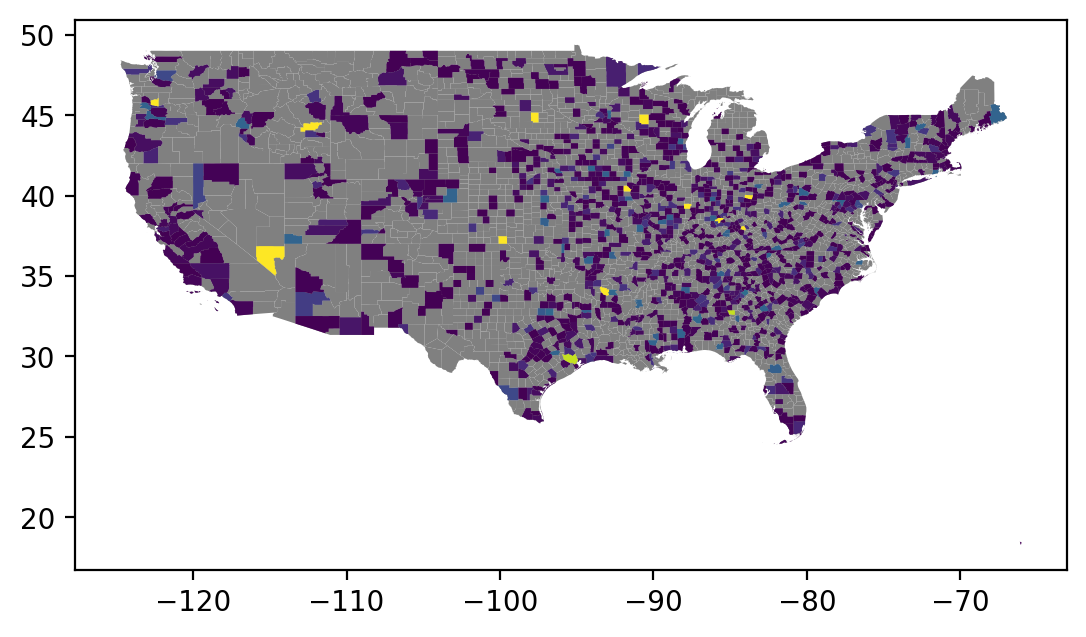

In [13]:
# Create a column containing a value of one, so when merged by county, this column will contain an incident count
merged_trafv4['count'] = 1

# Group by the county name
merged_traf_count = merged_trafv4.groupby(['county_name_y']).sum()

# Merge the NIBRS trafficking data with the list of counties
county_map = pd.merge(us_counties, merged_traf_count, left_on='NAME', right_on='county_name_y', how='left')

# Remove Alaska, Hawaii, and US outlying territories for the sake of map legibility
no_AK_county_map = county_map[county_map['STATEFP'] != '02']
lower_48 = no_AK_county_map[no_AK_county_map['STATEFP'] != '15']
exclude_statefps = ['02', '15', '66', '72', '60','61','62','63', '64', '66','68', '69', '70', '74','78', '81','84','86','67','89','71','76','95','79']
clean_county_map = county_map[~county_map['STATEFP'].isin(exclude_statefps)]

# Plot the data with a cleaned basemap which also removes the above areas
ax = clean_county_map.plot(color='grey')
lower_48.plot(ax=ax, column='count', figsize=(10,6))

In [15]:
# Save the figure
plt.savefig('us_nibrs.png', format='png')

<Figure size 640x480 with 0 Axes>

In [58]:
# Save the data as a csv
lower_48.to_csv('CleanedNIBRS2022v2.csv', index=True)

In [16]:
# Read in the SOB data from the Yelp API
SOBlist = pd.read_csv('~/Human Trafficking Project/Data/SOB_full_list.csv')

# Create a geometry column with Point objects
SOBlist['geometry'] = SOBlist.apply(lambda row: Point(row['coordinates.longitude'], row['coordinates.latitude']), axis=1)

# Convert to a GeoDataFrame
SOBlist_df = gpd.GeoDataFrame(SOBlist, geometry='geometry', crs='EPSG:4326')

SOBlist_df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,location.zip_code,location.country,location.state,location.display_address,attributes.business_temp_closed,attributes.open24_hours,attributes.waitlist_reservation,videoorsexshop,attributes.menu_url,geometry
0,jBmp_hZ5USy3YvkWCs9YYg,pony-bama-huntsville,Pony Bama,https://s3-media3.fl.yelpcdn.com/bphoto/NDYDCD...,False,https://www.yelp.com/biz/pony-bama-huntsville?...,3,"[{'alias': 'adultentertainment', 'title': 'Adu...",4.7,[],...,35811,US,AL,"['141 Ware Dr NE', 'Huntsville, AL 35811']",NaN,NaN,NaN,False,NaN,POINT (-86.53766 34.79332)
1,UX4uy4GmntBeT0lilRnAnA,fantasia-huntsville,Fantasia,https://s3-media2.fl.yelpcdn.com/bphoto/sCfj4Q...,False,https://www.yelp.com/biz/fantasia-huntsville?a...,2,"[{'alias': 'stripclubs', 'title': 'Strip Clubs'}]",1.0,[],...,35803,US,AL,"['14068 Memorial Pkwy SW', 'Huntsville, AL 358...",NaN,NaN,NaN,False,NaN,POINT (-86.56437 34.58211)
2,zmw3FrT7hNS_R8mZYNc9GQ,foxx-tails-huntsville,Foxx Tails,NaN,False,https://www.yelp.com/biz/foxx-tails-huntsville...,1,"[{'alias': 'adultentertainment', 'title': 'Adu...",1.0,[],...,35811,US,AL,"['1066 Winchester Rd NE', 'Huntsville, AL 35811']",NaN,NaN,NaN,False,NaN,POINT (-86.53347 34.79901)
3,W56kYLKy6DY3hJh7iX58TQ,jimmys-lounge-madison,Jimmy's Lounge,https://s3-media2.fl.yelpcdn.com/bphoto/wm7aPw...,False,https://www.yelp.com/biz/jimmys-lounge-madison...,3,"[{'alias': 'adultentertainment', 'title': 'Adu...",2.3,[],...,35758,US,AL,"['8700 Hwy 72 W', 'Madison, AL 35758']",NaN,NaN,NaN,False,NaN,POINT (-86.78456 34.74769)
4,w6h4Y1b16ovT6NuOGmyfZA,rocket-city-showgirls-huntsville,Rocket City Showgirls,NaN,False,https://www.yelp.com/biz/rocket-city-showgirls...,1,"[{'alias': 'adultentertainment', 'title': 'Adu...",1.0,[],...,35806,US,AL,"['6400 University Dr NW', 'Huntsville, AL 35806']",NaN,NaN,NaN,False,NaN,POINT (-86.68613 34.74791)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,ZR8c8nGSN-rpofKu0l24bg,sa-party-bus-san-antonio,SA Party Bus,NaN,False,https://www.yelp.com/biz/sa-party-bus-san-anto...,1,"[{'alias': 'danceclubs', 'title': 'Dance Clubs...",5.0,[],...,78223,US,TX,"['5202 Ferrington Dr', 'San Antonio, TX 78223']",NaN,NaN,NaN,False,NaN,POINT (-98.43173 29.37349)
541,kilBaJeGKxlYUkT0D12cEw,coyote-ugly-san-antonio,Coyote Ugly,https://s3-media1.fl.yelpcdn.com/bphoto/2rSai0...,False,https://www.yelp.com/biz/coyote-ugly-san-anton...,203,"[{'alias': 'bars', 'title': 'Bars'}, {'alias':...",2.3,[],...,78205,US,TX,"['409 East Commerce St', 'San Antonio, TX 78205']",NaN,NaN,NaN,False,NaN,POINT (-98.48859 29.42406)
542,KBg7G1nOgThsd_qnKM4TTA,hardbodies-male-dancers-san-antonio,Hardbodies Male Dancers,https://s3-media3.fl.yelpcdn.com/bphoto/3a0S_P...,False,https://www.yelp.com/biz/hardbodies-male-dance...,28,"[{'alias': 'adultentertainment', 'title': 'Adu...",2.6,[],...,78212,US,TX,"['2726 N St Marys', 'San Antonio, TX 78212']",NaN,NaN,NaN,False,NaN,POINT (-98.48612 29.45092)
543,rxkUGevIwnnn_bHpu3Vcdw,club-eden-san-antonio,Club Eden,NaN,False,https://www.yelp.com/biz/club-eden-san-antonio...,1,"[{'alias': 'adultentertainment', 'title': 'Adu...",5.0,[],...,78217,US,TX,"['4250 Thousand Oaks Dr', 'San Antonio, TX 782...",NaN,NaN,NaN,False,NaN,POINT (-98.41075 29.55191)


In [19]:
# Check the crs of the GeoDataFrame
crs = SOBlist_df.crs

# Print the CRS
print("Coordinate Reference System (CRS):", crs)

Coordinate Reference System (CRS): EPSG:4326


In [17]:
# Define a function to count the number of points within polygons in a GeoDataFrame
def count_points_in_polygons(points_gdf, polygons_gdf):
    """
    Count how many points fall into each polygon in polygons_gdf.

    Parameters:
    - points_gdf: GeoDataFrame containing points.
    - polygons_gdf: GeoDataFrame containing polygons.

    Returns:
    - DataFrame with polygon IDs and corresponding point counts.
    """
    # Ensure points and polygons have the same CRS
    points_gdf = points_gdf.to_crs(polygons_gdf.crs)

    # Perform spatial join to count points within each polygon
    points_in_polygons = gpd.sjoin(points_gdf, polygons_gdf, op='within')

    # Group by polygon and count points
    point_counts = points_in_polygons.groupby('name_and_fips').size().reset_index(name='point_count')

    return point_counts

#Counting the number of proxy SOBs per county in Texas
SOB_count = count_points_in_polygons(SOBlist_df, us_counties)
SOB_count

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,name_and_fips,point_count
0,Ascension 22,1
1,Baldwin 01,2
2,Bernalillo 35,3
3,Bexar 48,16
4,Broward 12,5
5,Clark 32,84
6,Dallas 48,28
7,Duval 12,16
8,East Baton Rouge 22,1
9,El Paso 48,9


In [18]:
# Merge the SOB counts by county with the county map for the continental US
HT_SOB_count = pd.merge(SOB_count, lower_48, left_on="name_and_fips", right_on="name_and_fips", how='left')
HT_SOB_count['point_count']

0      1
1      2
2      3
3     16
4      5
5     84
6     28
7     16
8      1
9      9
10     4
11    20
12     1
13    22
14     2
15     4
16     1
17     1
18     1
19     2
20    97
21     6
22    36
23    46
24    12
25    14
26    12
27     2
28     7
29    10
30    20
31     1
32    14
33     1
34     2
35    17
36    19
37     3
38     1
39     1
40     1
Name: point_count, dtype: int64

In [19]:
# Save the data as a csv
HT_SOB_count.to_csv('HT_SOB_count.csv', index=False)

In [20]:
# Convert to a GeoDataFrame
HT_SOB_count_gdf = gpd.GeoDataFrame(HT_SOB_count, geometry=HT_SOB_count['geometry'])

<Axes: >

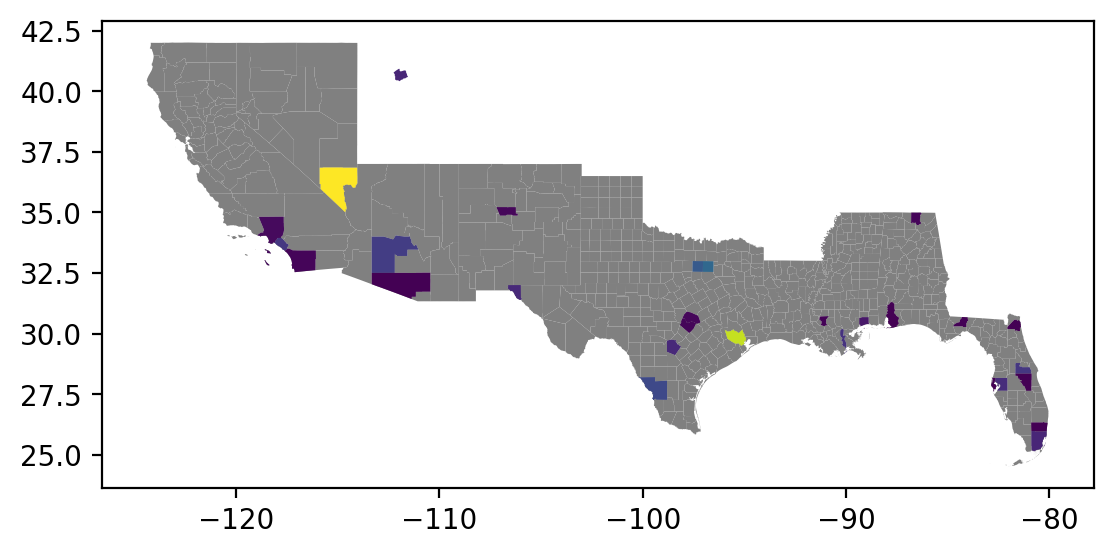

In [21]:
#--------- Plotting human trafficking in the southern United States ------------

# Define included states
include_statefps = ['35', '22', '12', '48', '32', '28', '01','04', '06']

# Include only those states with boolean logic
south_counties = lower_48[lower_48['STATEFP'].isin(include_statefps)]

# Plot a grey base map
ax = south_counties.plot(color='gray')

# Plot the counties with reported human trafficking incidents in corresponding colors
HT_SOB_count_gdf.plot(column='count', ax=ax, figsize=(50,10))

<Axes: >

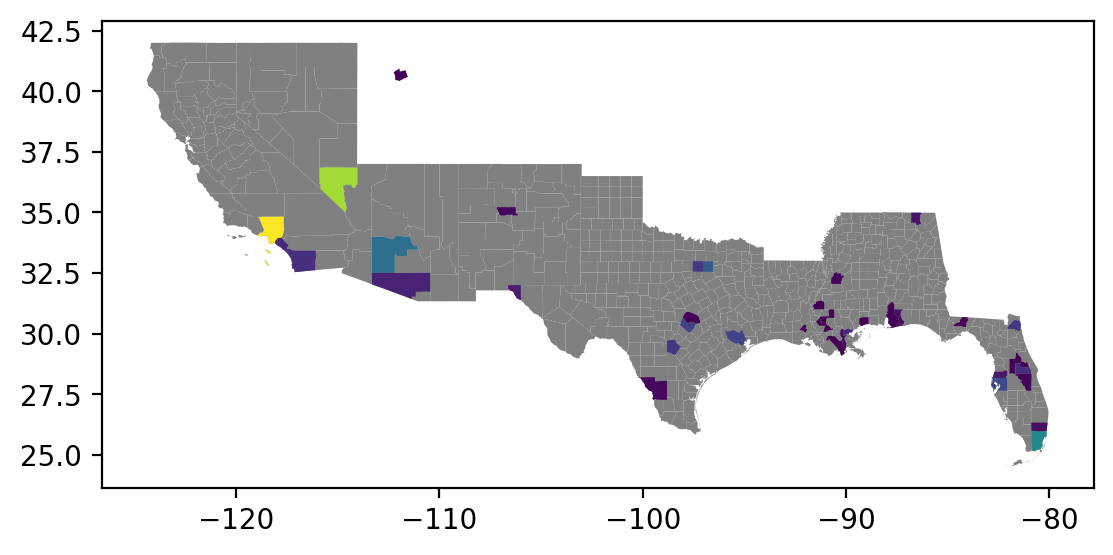

In [22]:
#------------- Plotting sexually oriented businesses in areas in and surrounding counties with HT incidents ---------------
ax = south_counties.plot(color='gray')
HT_SOB_count_gdf.plot(column='point_count', ax=ax, figsize=(50,10))

<Axes: >

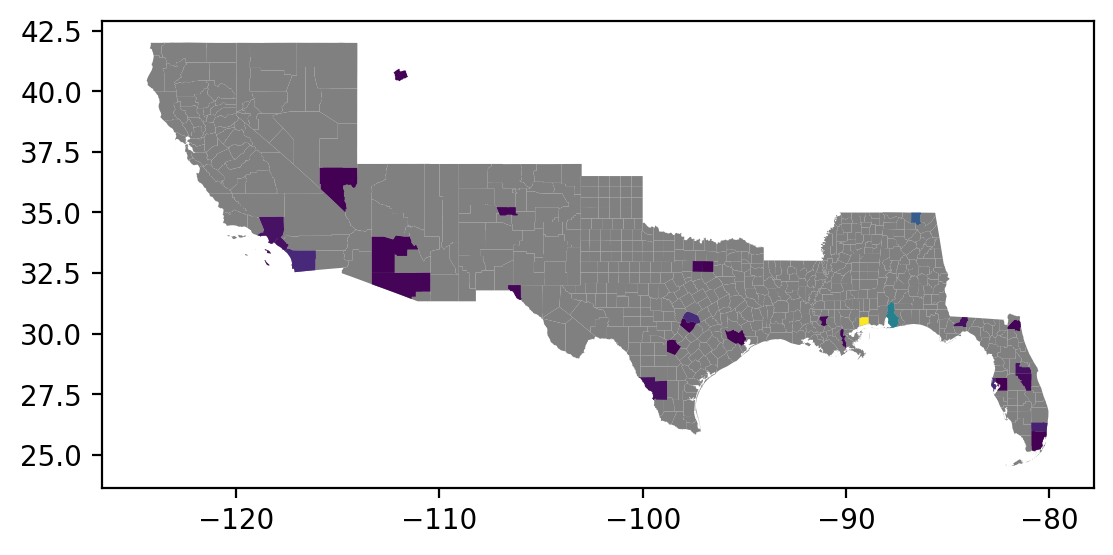

In [23]:
#---------- Plotting human trafficking incidents by county divided by the population -----------
HT_SOB_count_gdf['HT_pop'] = HT_SOB_count_gdf['count']/HT_SOB_count_gdf['population_y'] 
ax = south_counties.plot(color='grey')
HT_SOB_count_gdf.plot(column='HT_pop', ax=ax, figsize=(50,5))

<Axes: >

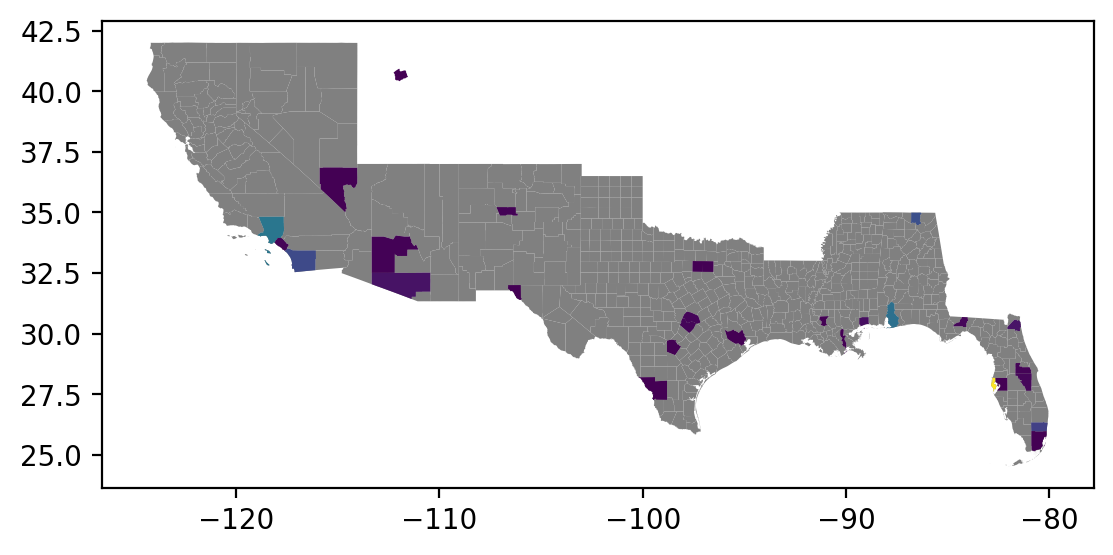

In [24]:
#-------- Plotting sexually-oriented businesses by county divided by population ----------
HT_SOB_count_gdf['SOB_pop'] = HT_SOB_count_gdf['point_count']/HT_SOB_count_gdf['population_y'] 
ax = south_counties.plot(color='gray')
HT_SOB_count_gdf.plot(column='SOB_pop', ax=ax, figsize=(50,5))

<Axes: >

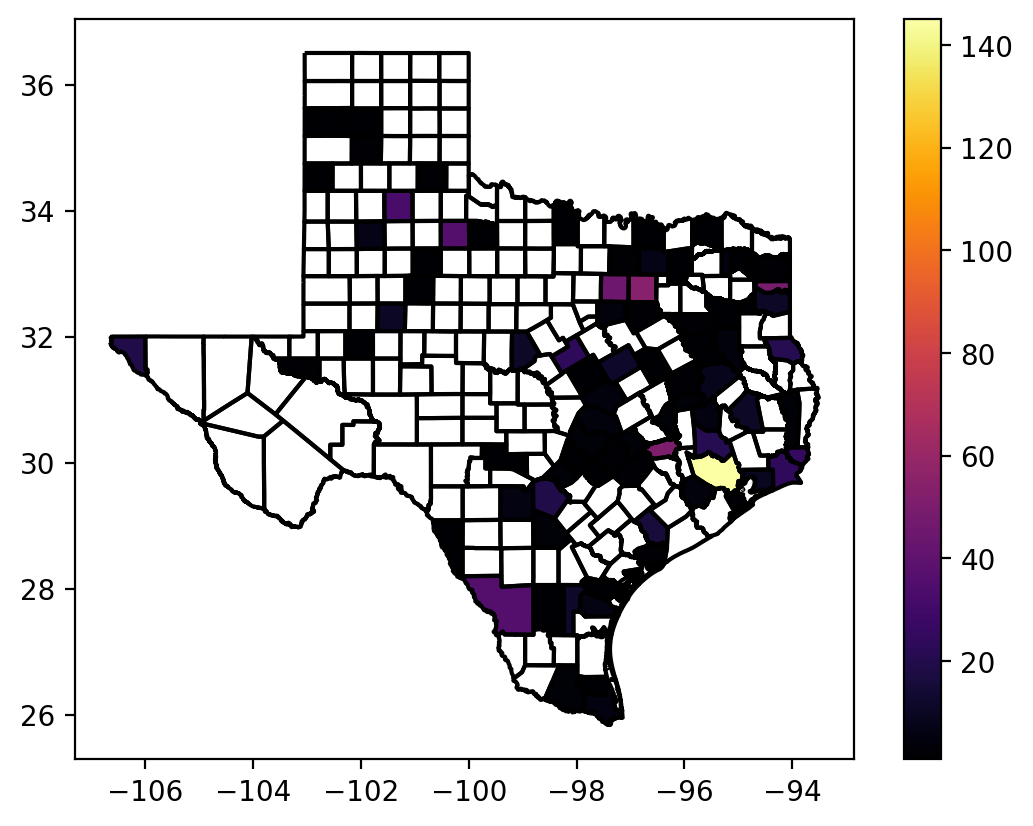

In [25]:
# Create a set of only counties in Texas
texas_counties = county_map[county_map['STATEFP'] == '48']

# Plot human trafficking incidents in Texas
ax = texas_counties.boundary.plot(color='black')
texas_counties.plot(ax=ax, column='count', figsize=(75,10), cmap='inferno',legend = True)
#legend_kwds={"label": "HT Incidents in 2022", "orientation": "horizontal"}

<Axes: >

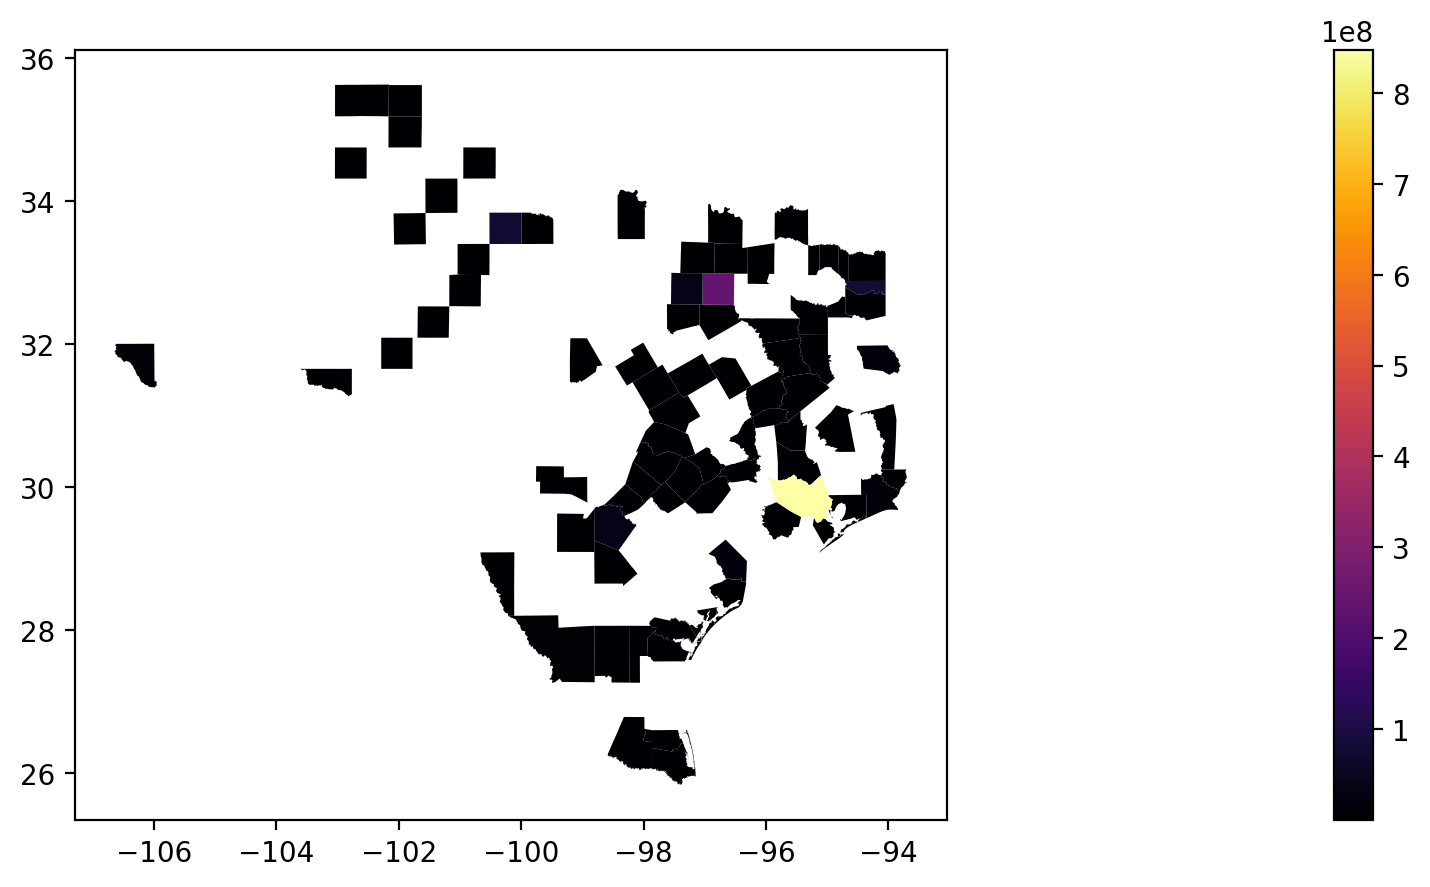

In [26]:
# Plot population for Texas
texas_counties.plot(column='population_y', figsize=(50,5), cmap='inferno',legend = True)

In [24]:
# Pulling only the counties with non-zero HT incidents
census_counties = lower_48.dropna(subset=['count'])

exclude_statefps2 = ['35', '22', '12', '48', '32', '28', '01','04', '06']

#New Mexico, Louisiana Florida Texas Nevada Mississippi Alabama Arizona California

# Filtering the DataFrame
clean_census_counties = census_counties[census_counties['STATEFP'].isin(exclude_statefps2)]

clean_census_counties

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,...,population_y,source,military,incorporated,timezone,ranking,zips,id,city_and_state,count
23,01,089,00161570,0500000US01089,01089,Madison,06,2076091216,28831382,"POLYGON ((-86.78955 34.56799, -86.78869 34.597...",...,102009.0,shapeshapeshape,0,3,America/Indiana/IndianapolisAmerica/ChicagoAme...,9.0,46016 46011 46012 46013 46014 46015 4601877864...,5.520041e+09,Anderson INMadisonville TXGlen Carbon IL,3.0
25,01,117,00161584,0500000US01117,01117,Shelby,06,2034112797,62537787,"POLYGON ((-87.02685 33.24646, -86.98289 33.246...",...,18748320.0,shapeshapeshapeshapeshapeshapeshapeshapeshapes...,0,21,America/ChicagoAmerica/ChicagoAmerica/ChicagoA...,27.0,38120 38127 38126 38107 38106 38105 38104 3810...,3.864033e+10,Memphis TNMemphis TNMemphis TNHarpersville ALB...,21.0
37,06,001,01675839,0500000US06001,06001,Alameda,06,1909598013,216923745,"POLYGON ((-122.34225 37.80556, -122.33412 37.8...",...,160602.0,shape,False,True,America/Los_Angeles,2.0,94541 94542 94544 94545 94587 94540 94543 94557,1.840020e+09,Hayward CA,1.0
40,06,013,01675903,0500000US06013,06013,Contra Costa,06,1857233047,225282636,"POLYGON ((-122.42976 37.96540, -122.41859 37.9...",...,2121942.0,shapeshapeshapeshapeshapeshapeshapeshapeshapes...,0,13,America/Los_AngelesAmerica/Los_AngelesAmerica/...,35.0,94531 945099456594553945539456594531 945099456...,2.392026e+10,Antioch CAPittsburg CAMartinez CAMartinez CAPi...,13.0
41,06,019,00277274,0500000US06019,06019,Fresno,06,15431404077,137345152,"POLYGON ((-120.90942 36.74770, -120.90725 36.7...",...,2901104.0,shapeshapeshapeshape,0,4,America/Los_AngelesAmerica/Los_AngelesAmerica/...,8.0,93740 93741 93730 93650 93702 93703 93701 9370...,7.360081e+09,Fresno CAFresno CAFresno CAFresno CA,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3122,28,123,00695782,0500000US28123,28123,Scott,06,1577902071,3001523,"POLYGON ((-89.78125 32.58979, -89.78113 32.592...",...,356353.0,shapeshapeshape,0,3,America/ChicagoAmerica/New_YorkAmerica/New_York,8.0,52802 52803 52801 52806 52807 52804 52805 5280...,5.520033e+09,Davenport IAGeorgetown KYGeorgetown KY,3.0
3129,48,201,01383886,0500000US48201,48201,Harris,06,4416454882,187141456,"MULTIPOLYGON (((-94.97839 29.68365, -94.97743 ...",...,848009666.0,shapeshapeshapeshapeshapeshapeshapeshapeshapes...,0,145,America/ChicagoAmerica/ChicagoAmerica/ChicagoA...,150.0,77069 77068 77061 77060 77063 77062 77065 7706...,2.668030e+11,Houston TXHouston TXHouston TXHouston TXHousto...,145.0
3163,04,025,00042809,0500000US04025,04025,Yavapai,06,21039796371,11501576,"POLYGON ((-113.33416 35.52804, -113.32957 35.5...",...,92108.0,shapeshape,0,2,America/PhoenixAmerica/Phoenix,6.0,86305 86301 86303 86313 86302 8630486305 86301...,3.680041e+09,Prescott AZPrescott AZ,2.0
3185,48,073,01383822,0500000US48073,48073,Cherokee,06,2727141729,23873001,"POLYGON ((-95.46214 32.12872, -95.46079 32.129...",...,139012.0,shapeshapeshapeshape,0,4,America/New_YorkAmerica/New_YorkAmerica/New_Yo...,12.0,30189 3018830189 3018830189 3018830114 30115,7.360061e+09,Woodstock GAWoodstock GAWoodstock GACanton GA,4.0


In [27]:
# Read in the casino data from Yelp.
casinos = pd.read_csv('~/Human Trafficking Project/Data/casinos.csv')

# Create a geometry column with Point objects
casinos['geometry'] = casinos.apply(lambda row: Point(row['coordinates.longitude'], row['coordinates.latitude']), axis=1)

# Convert to a GeoDataFrame
casinos_gdf = gpd.GeoDataFrame(casinos, geometry='geometry', crs='EPSG:4326')

#a function to count the number of points within polygons in a GeoDataFrame
def count_points_in_polygons(points_gdf, polygons_gdf):
    """
    Count how many points fall into each polygon in polygons_gdf.

    Parameters:
    - points_gdf: GeoDataFrame containing points.
    - polygons_gdf: GeoDataFrame containing polygons.

    Returns:
    - DataFrame with polygon IDs and corresponding point counts.
    """
    # Ensure points and polygons have the same CRS
    points_gdf = points_gdf.to_crs(polygons_gdf.crs)

    # Perform spatial join to count points within each polygon
    points_in_polygons = gpd.sjoin(points_gdf, polygons_gdf, op='within')

    # Group by polygon and count points
    point_counts = points_in_polygons.groupby('name_and_fips').size().reset_index(name='point_count')

    return point_counts

# Counting the number of proxy SOBs per county in Texas
casino_count = count_points_in_polygons(casinos_gdf, us_counties)
casino_count

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,name_and_fips,point_count
0,Alachua 12,1
1,Bernalillo 35,7
2,Bexar 48,9
3,Brevard 12,2
4,Broward 12,12
5,Clark 32,240
6,Clay 12,1
7,Collin 48,1
8,Dallas 48,10
9,Doña Ana 35,2


In [28]:
# Merge the casino counts by county onto the Census data set containing the geometry
casino_counts = pd.merge(casino_count, us_counties, left_on="name_and_fips", right_on="name_and_fips", how='left')
casino_counts

,name_and_fips,point_count,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,Alachua 12,1,12,001,00308548,0500000US12001,12001,Alachua,06,2266324954,242877007,"POLYGON ((-82.65855 29.83014, -82.65551 29.829..."
1,Bernalillo 35,7,35,001,01702363,0500000US35001,35001,Bernalillo,06,3007639331,15855131,"POLYGON ((-107.19676 35.21946, -107.17087 35.2..."
2,Bexar 48,9,48,029,01383800,0500000US48029,48029,Bexar,06,3212140683,41079712,"POLYGON ((-98.80655 29.69071, -98.80277 29.694..."
3,Brevard 12,2,12,009,00295749,0500000US12009,12009,Brevard,06,2629306677,1403367455,"POLYGON ((-80.98725 28.61300, -80.98469 28.613..."
4,Broward 12,12,12,011,00295753,0500000US12011,12011,Broward,06,3116026236,310052487,"POLYGON ((-80.88123 26.33381, -80.53990 26.334..."
5,Clark 32,240,32,003,00863600,0500000US32003,32003,Clark,06,20439281456,438411489,"POLYGON ((-115.89692 36.84208, -115.84019 36.8..."
6,Clay 12,1,12,019,00295726,0500000US12019,12019,Clay,06,1566375291,100402899,"POLYGON ((-82.04941 30.18693, -82.02031 30.186..."
7,Collin 48,1,48,085,01383828,0500000US48085,48085,Collin,06,2178894500,116215462,"POLYGON ((-96.84393 32.99942, -96.84383 33.005..."
8,Dallas 48,10,48,113,01383842,0500000US48113,48113,Dallas,06,2258614866,94698972,"POLYGON ((-97.03820 32.56003, -97.03808 32.566..."
9,Doña Ana 35,2,35,013,00929109,0500000US35013,35013,Doña Ana,06,9863129095,17626170,"POLYGON ((-107.29963 32.60537, -107.29947 32.7..."


In [29]:
# Save the resulting dataframe
casino_counts.to_csv('casino_count.csv', index=False)

In [30]:
# Aggregate the city and state columns to create a unique name for each municipality
uscities['city/state'] = uscities[["city","state_id"]].agg(",".join, axis=1)

In [6]:
# Read in the new SOB list
sob_cities = pd.read_csv('~/Human Trafficking Project/Data/SOBfull.csv')
sob_cities

,Unnamed: 0.1,id,alias,name,image_url,is_closed,url,review_count,categories,rating,...,location.zip_code,location.country,location.state,location.display_address,attributes.business_temp_closed,attributes.open24_hours,attributes.waitlist_reservation,videoorsexshop,attributes.menu_url,Unnamed: 0
0,0,jBmp_hZ5USy3YvkWCs9YYg,pony-bama-huntsville,Pony Bama,https://s3-media3.fl.yelpcdn.com/bphoto/NDYDCD...,False,https://www.yelp.com/biz/pony-bama-huntsville?...,3,"[{'alias': 'adultentertainment', 'title': 'Adu...",4.7,...,35811,US,AL,"['141 Ware Dr NE', 'Huntsville, AL 35811']",NaN,NaN,NaN,False,NaN,NaN
1,1,UX4uy4GmntBeT0lilRnAnA,fantasia-huntsville,Fantasia,https://s3-media2.fl.yelpcdn.com/bphoto/sCfj4Q...,False,https://www.yelp.com/biz/fantasia-huntsville?a...,2,"[{'alias': 'stripclubs', 'title': 'Strip Clubs'}]",1.0,...,35803,US,AL,"['14068 Memorial Pkwy SW', 'Huntsville, AL 358...",NaN,NaN,NaN,False,NaN,NaN
2,2,zmw3FrT7hNS_R8mZYNc9GQ,foxx-tails-huntsville,Foxx Tails,NaN,False,https://www.yelp.com/biz/foxx-tails-huntsville...,1,"[{'alias': 'adultentertainment', 'title': 'Adu...",1.0,...,35811,US,AL,"['1066 Winchester Rd NE', 'Huntsville, AL 35811']",NaN,NaN,NaN,False,NaN,NaN
3,3,W56kYLKy6DY3hJh7iX58TQ,jimmys-lounge-madison,Jimmy's Lounge,https://s3-media2.fl.yelpcdn.com/bphoto/wm7aPw...,False,https://www.yelp.com/biz/jimmys-lounge-madison...,3,"[{'alias': 'adultentertainment', 'title': 'Adu...",2.3,...,35758,US,AL,"['8700 Hwy 72 W', 'Madison, AL 35758']",NaN,NaN,NaN,False,NaN,NaN
4,4,w6h4Y1b16ovT6NuOGmyfZA,rocket-city-showgirls-huntsville,Rocket City Showgirls,NaN,False,https://www.yelp.com/biz/rocket-city-showgirls...,1,"[{'alias': 'adultentertainment', 'title': 'Adu...",1.0,...,35806,US,AL,"['6400 University Dr NW', 'Huntsville, AL 35806']",NaN,NaN,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1894,3370,XvggtVuE0c_KNSQJmXEGnw,twin-perks-espresso-gladstone-2,Twin Perks Espresso,https://s3-media3.fl.yelpcdn.com/bphoto/lkeXF0...,False,https://www.yelp.com/biz/twin-perks-espresso-g...,6,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.3,...,97027,US,OR,"['19800 McLoughlin Blvd', 'Gladstone, OR 97027']",NaN,NaN,NaN,NaN,NaN,2825.0
1895,3380,3BK7MEDl6ejpfNCvNmvJQA,adult-world-las-vegas,Adult World,https://s3-media2.fl.yelpcdn.com/bphoto/Kn7uRg...,False,https://www.yelp.com/biz/adult-world-las-vegas...,29,"[{'alias': 'adult', 'title': 'Adult Shops'}, {...",3.5,...,89102,US,NV,"['3781 Meade Ave', 'Las Vegas, NV 89102']",NaN,NaN,NaN,NaN,NaN,2835.0
1896,3461,RUS032hlVRwGlsJ_joc9rA,players-lounge-detroit,Player's Lounge,https://s3-media4.fl.yelpcdn.com/bphoto/-7VBoa...,False,https://www.yelp.com/biz/players-lounge-detroi...,17,"[{'alias': 'lounges', 'title': 'Lounges'}, {'a...",2.6,...,48205,US,MI,"['13710 E 8 Mile Rd', 'Detroit, MI 48205']",NaN,NaN,NaN,NaN,NaN,2916.0
1897,3462,i-cIt989aOZiiOEt57NCvA,tycoons-executive-club-detroit,Tycoon's Executive Club,https://s3-media4.fl.yelpcdn.com/bphoto/ECPgp1...,False,https://www.yelp.com/biz/tycoons-executive-clu...,4,"[{'alias': 'stripclubs', 'title': 'Strip Clubs'}]",3.5,...,48205,US,MI,"['12210 E 8 Mile Rd', 'Detroit, MI 48205']",NaN,NaN,NaN,NaN,NaN,2917.0


In [7]:
# Create a geometry column with Point objects
sob_cities['geometry'] = sob_cities.apply(lambda row: Point(row['coordinates.longitude'], row['coordinates.latitude']), axis=1)

# Convert to a GeoDataFrame
sob_cities_gdf = gpd.GeoDataFrame(sob_cities, geometry='geometry', crs='EPSG:4326')

#a function to count the number of points within polygons in a GeoDataFrame
def count_points_in_polygons(points_gdf, polygons_gdf):
    """
    Count how many points fall into each polygon in polygons_gdf.

    Parameters:
    - points_gdf: GeoDataFrame containing points.
    - polygons_gdf: GeoDataFrame containing polygons.

    Returns:
    - DataFrame with polygon IDs and corresponding point counts.
    """
    # Ensure points and polygons have the same CRS
    points_gdf = points_gdf.to_crs(polygons_gdf.crs)

    # Perform spatial join to count points within each polygon
    points_in_polygons = gpd.sjoin(points_gdf, polygons_gdf, op='within')

    # Group by polygon and count points
    point_counts = points_in_polygons.groupby('name_and_fips').size().reset_index(name='point_count')

    return point_counts

#Counting the number of proxy SOBs per county in Texas
sob_count = count_points_in_polygons(sob_cities_gdf, us_counties)
sob_count

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3577: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,name_and_fips,point_count
0,Ada 16,10
1,Adams 08,12
2,Adams 55,1
3,Arapahoe 08,4
4,Arlington 51,1
...,...,...
256,Williamson 48,3
257,Winnebago 55,1
258,Woodbury 19,1
259,Worcester 25,6


In [11]:
# Merge the SOB counts onto the Census data set containing the geometry
sob_citiesv2 = pd.merge(sob_count, us_counties, left_on='name_and_fips', right_on='name_and_fips', how='left')

# Rename the 'point_count' column to 'SOB_number'
sob_citiesv2.rename(columns={'point_count': 'SOB_number'}, inplace=True)

sob_citiesv2

,name_and_fips,SOB_number,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,Ada 16,10,16,001,00395066,0500000US16001,16001,Ada,06,2724688230,22176177,"POLYGON ((-116.51345 43.43706, -116.51349 43.4..."
1,Adams 08,12,08,001,00198116,0500000US08001,08001,Adams,06,3020592854,44447105,"POLYGON ((-105.05329 39.85676, -105.05323 39.8..."
2,Adams 55,1,55,001,01581060,0500000US55001,55001,Adams,06,1672240387,108332661,"POLYGON ((-90.02638 44.08721, -90.02595 44.091..."
3,Arapahoe 08,4,08,005,00198118,0500000US08005,08005,Arapahoe,06,2066632437,19499590,"MULTIPOLYGON (((-104.89879 39.68570, -104.8987..."
4,Arlington 51,1,51,013,01480097,0500000US51013,51013,Arlington,06,67333000,273562,"POLYGON ((-77.16811 38.89652, -77.16421 38.899..."
...,...,...,...,...,...,...,...,...,...,...,...,...
259,Williamson 48,3,48,491,01384031,0500000US48491,48491,Williamson,06,2896482213,41627400,"POLYGON ((-98.04989 30.62415, -98.03034 30.660..."
260,Winnebago 55,1,55,139,01581129,0500000US55139,55139,Winnebago,06,1125846130,372645352,"POLYGON ((-88.88667 44.24262, -88.85030 44.242..."
261,Woodbury 19,1,19,193,00465285,0500000US19193,19193,Woodbury,06,2260790985,12793704,"POLYGON ((-96.49878 42.56104, -96.46085 42.561..."
262,Worcester 25,6,25,027,00606940,0500000US25027,25027,Worcester,06,3912564078,177449060,"POLYGON ((-72.31363 42.39640, -72.31509 42.398..."


In [12]:
# Save the dataframe as a csv
sob_citiesv2.to_csv('sob_county_count_final.csv', index=False)

In [9]:
# Read in the above csv
sobs = pd.read_csv('~/Human Trafficking Project/Data/sob_county_count_final.csv')

# Use the Well Known Text package in shapely to recognize the existing geometry objects
sobs['geometry'] = sobs['geometry'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
sobs_gdf = gpd.GeoDataFrame(sobs, geometry='geometry', crs='EPSG:4326')

<Axes: >

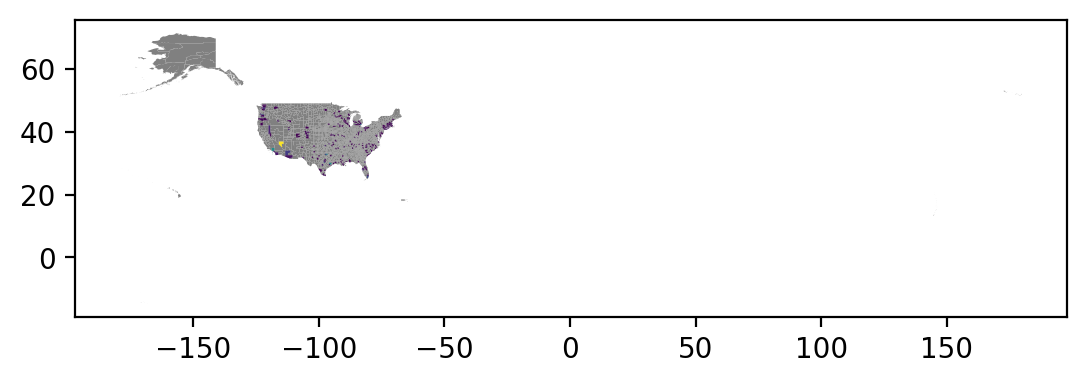

In [12]:
# Plot the GeoDateFrame
ax=us_counties.plot(color='grey')
sobs_gdf.plot(column='SOB_number', ax=ax)